# Molecular property prediction combining CNN and GRU Neural Networks with embedding layer for SMILES-Based Regression

The entire work was recorded in a repositori in Github, https://github.com/CCT-Dublin/msc-da-integrated-ca1-sem2-RKeuchkerian/commits/main/

## Introduccion

SMILES (Simplified Molecular Input Line Entry System) is a line notation that encodes molecular structures as text strings. In computational chemistry, deep learning models using SMILES are gaining traction for molecular property prediction. This notebook explores a hybrid neural network combining embeddings, convolutional layers (Conv1D), and recurrent layers (GRU), applied to predict polar area values.


## Import packages

In [201]:
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, GRU, Dense, Dropout, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import MolToSmiles

## Load dataset and EDA

The dataset was downloaded from PubChem (Apodaca, R., 2022. Balsa: A Compact Line Notation Based on SMILES. https://doi.org/10.26434/chemrxiv-2022-01ltp)

Visualización del histograma de polar area value

Distribución de longitudes SMILES

Null cleaning

In [248]:
file_id = "1j6ZyeG5lN2cya1IuSCrP7hcIB7USpsX9"
url = f"https://drive.google.com/uc?id={file_id}"

# Descargar archivo
output = "dataset.csv"
#gdown.download(url, output, quiet=False)

# Leer el archivo en pandas
df = pd.read_csv(output)
df.head()

C:\Users\romin\AppData\Local\Temp\ipykernel_15552\3859884612.py:9: DtypeWarning: Columns (30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output)


,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,gpidcnt,gpfamilycnt,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,89594,Nicotine,nicotine|L-Nicotine|54-11-5|(-)-Nicotine|(S)-N...,162.23,C10H14N2,16.1,147.0,1.2,12,0,...,123782,37630,Nicotine,Agrochemical Information|Biological Test Resul...,20,421|426|427|433|434|435|445|530|540|541|542|54...,20040916,001Chemical|10X CHEM|1st Scientific|3B Scienti...,Chemical Vendors|Curation Efforts|Governmental...,N - Nervous system > N07 - Other nervous syste...
1,40326,Permethrin,Permethrin|52645-53-1|Pounce|Permethrine|Perme...,391.30,C21H20Cl2O3,35.5,521.0,6.5,26,0,...,66189,19536,Permethrin,Agrochemical Information|Biological Test Resul...,19,880|881|894|1030|1188|1379|1452|1457|1460|1463...,20050327,10X CHEM|3B Scientific (Wuhan) Corp|3WAY PHARM...,Chemical Vendors|Curation Efforts|Governmental...,D004791 - Enzyme Inhibitors|D010575 - Pesticid...
2,14982,Glycyrrhizin,Glycyrrhizic acid|glycyrrhizin|1405-86-3|Glycy...,822.90,C42H62O16,267.0,1730.0,3.7,58,8,...,53880,29325,Glycyrrhizic Acid,Biological Test Results|Interactions and Pathw...,19,2517|86199|86201|265377|287075|288766|297145|2...,20040916,001Chemical|10X CHEM|3WAY PHARM INC|A2B Chem|A...,Chemical Vendors|Curation Efforts|Governmental...,A - Alimentary tract and metabolism > A05 - Bi...
3,2519,Caffeine,"caffeine|58-08-2|Guaranine|1,3,7-Trimethylxant...",194.19,C8H10N4O2,58.4,293.0,-0.1,14,0,...,138189,44732,Caffeine,Agrochemical Information|Biological Test Resul...,19,155|157|161|165|167|175|192|248|256|316|328|35...,20040916,001Chemical|10X CHEM|3B Scientific (Wuhan) Cor...,Chemical Vendors|Curation Efforts|Governmental...,C78272 - Agent Affecting Nervous System > C477...
4,338,Salicylic Acid,salicylic acid|2-Hydroxybenzoic acid|69-72-7|o...,138.12,C7H6O3,57.5,133.0,2.3,10,2,...,455233,155668,Salicylic Acid,Biological Test Results|Interactions and Pathw...,19,155|157|161|165|167|175|179|248|485|568|583|59...,20040916,001Chemical|10X CHEM|1st Scientific|3B Scienti...,Chemical Vendors|Curation Efforts|Governmental...,C254 - Anti-Infective Agent > C52588 - Antibac...


In [212]:
df.describe()

,cid,mw,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,exactmass,...,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,annothitcnt,cidcdate
count,1.519660e+05,151966.000000,151966.000000,151966.000000,145653.000000,151966.000000,151966.000000,151966.000000,151966.000000,151966.000000,...,151966.000000,151966.000000,151966.000000,151966.000000,151966.000000,151966.000000,151966.000000,151966.000000,151966.000000,1.519660e+05
mean,1.270347e+08,489.290209,111.024263,779.884071,3.242967,34.592429,2.127910,7.450890,6.554209,488.808294,...,0.971665,0.486938,0.064995,0.063883,0.001112,30.340392,181.043477,57.065982,4.026769,2.018060e+07
std,4.358054e+07,189.191700,58.912667,411.605047,1.864625,13.077992,1.872734,3.409217,4.357122,189.038812,...,2.119759,1.371000,0.296450,0.292818,0.043896,1395.619164,4230.621498,1704.444532,1.585653,4.583029e+04
min,1.420000e+02,16.030000,0.000000,0.000000,-32.700000,1.000000,0.000000,0.000000,0.000000,16.029200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.004092e+07
25%,1.183480e+08,396.500000,80.300000,572.000000,2.100000,28.000000,1.000000,5.000000,4.000000,396.161250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,2.016022e+07
50%,1.385230e+08,461.900000,103.000000,720.000000,3.200000,33.000000,2.000000,7.000000,6.000000,461.222500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,4.000000,2.019072e+07
75%,1.569076e+08,533.000000,127.000000,886.000000,4.300000,38.000000,3.000000,9.000000,8.000000,532.302000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,5.000000,2.021111e+07
max,1.728665e+08,9010.220000,2700.000000,19800.000000,61.100000,441.000000,76.000000,153.000000,179.000000,9010.220000,...,51.000000,68.000000,11.000000,11.000000,6.000000,238118.000000,733442.000000,375561.000000,20.000000,2.025031e+07


Considerations:
The SMILES representation is entirely dependent on the order of atoms and bonds. Two different representations can refer to the same molecule, but a model can interpret them as distinct structures.

In [252]:
df_polararea = df[["smiles", "polararea"]].dropna()  # Keep only SMILES & polar area columns
df_polararea.head()

,smiles,polararea
0,CN1CCC[C@H]1C2=CN=CC=C2,16.1
1,CC1(C(C1C(=O)OCC2=CC(=CC=C2)OC3=CC=CC=C3)C=C(C...,35.5
2,C[C@]12CC[C@](C[C@H]1C3=CC(=O)[C@@H]4[C@]5(CC[...,267.0
3,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,58.4
4,C1=CC=C(C(=C1)C(=O)O)O,57.5


In [50]:
print(df_polararea.isnull().sum())

smiles       0
polararea    0
dtype: int64


In [51]:
df_polararea.shape

(151966, 2)

In [214]:
df_polararea.describe()

,polararea
count,151966.000000
mean,111.024263
std,58.912667
min,0.000000
25%,80.300000
50%,103.000000
75%,127.000000
max,2700.000000


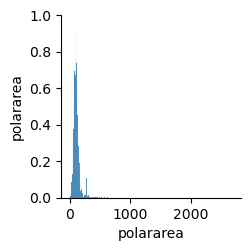

In [52]:
sns.pairplot(df_polararea)

## Deep Learning model

## Data preparation

RDkit used as a tool for validation, cleaning, and transformation of SMILES data

SMILES strings are tokenized into character-level sequences, padded to a fixed length, and reshaped for model compatibility. 

Polar area values are normalized using MinMax scaling and reshape to be used in GRU.


### Data Cleaning and validation.

In [218]:
# 1. Check if the 'smiles' column exists
if 'smiles' in df_polararea.columns:
    
    # 2. Create the 'mol' column with RDKit molecule objects
    df_polararea['mol'] = df_polararea['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
    
    # 3. Count invalid SMILES
    n_invalid = df_polararea['mol'].isnull().sum()
    print(f"Number of invalid SMILES: {n_invalid} out of {len(df_polararea)}")

    # 4. Remove invalid SMILES
    df_clean = df_polararea.dropna(subset=['mol']).copy()
    print(f"{len(df_clean)} valid SMILES remaining.")

    # 5. Optional: Save the cleaned DataFrame
    df_clean.to_csv('cleaned_smiles.csv', index=False)
    print("Cleaned file saved as 'cleaned_smiles.csv'.")

else:
    print("❌ Error: 'smiles' column does not exist in the DataFrame.")

[19:57:39] WARNING: not removing hydrogen atom without neighbors
[19:57:39] WARNING: not removing hydrogen atom without neighbors
[19:57:39] WARNING: not removing hydrogen atom without neighbors
[19:57:39] WARNING: not removing hydrogen atom without neighbors
[19:57:39] WARNING: not removing hydrogen atom without neighbors
[19:57:39] WARNING: not removing hydrogen atom without neighbors
[19:57:39] WARNING: not removing hydrogen atom without neighbors
[19:57:40] WARNING: not removing hydrogen atom without neighbors
[19:57:40] WARNING: not removing hydrogen atom without neighbors
[19:57:41] WARNING: not removing hydrogen atom without neighbors
[19:57:41] WARNING: not removing hydrogen atom without neighbors
[19:57:41] WARNING: not removing hydrogen atom without neighbors
[19:57:41] WARNING: not removing hydrogen atom without neighbors
[19:57:41] WARNING: not removing hydrogen atom without neighbors
[19:57:41] WARNING: not removing hydrogen atom without neighbors
[19:57:43] WARNING: not r

Number of invalid SMILES: 7 out of 151966
151959 valid SMILES remaining.
Cleaned file saved as 'cleaned_smiles.csv'.


In [219]:
df_clean.head()

,smiles,polararea,mol
0,CN1CCC[C@H]1C2=CN=CC=C2,16.1,<rdkit.Chem.rdchem.Mol object at 0x0000023E18C...
1,CC1(C(C1C(=O)OCC2=CC(=CC=C2)OC3=CC=CC=C3)C=C(C...,35.5,<rdkit.Chem.rdchem.Mol object at 0x0000023E18C...
2,C[C@]12CC[C@](C[C@H]1C3=CC(=O)[C@@H]4[C@]5(CC[...,267.0,<rdkit.Chem.rdchem.Mol object at 0x0000023E18C...
3,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,58.4,<rdkit.Chem.rdchem.Mol object at 0x0000023E18C...
4,C1=CC=C(C(=C1)C(=O)O)O,57.5,<rdkit.Chem.rdchem.Mol object at 0x00000240CD3...


### Split data
he dataset was randomly split into training and testing subsets using an 80/20 ratio. The training set was used to fit the model, while the test set was held out for final evaluation. A fixed random seed was applied to ensure reproducibility of the split.

In [222]:
from sklearn.model_selection import train_test_split

# 1. Build vocabulary of unique characters in SMILES
unique_chars = sorted(set("".join(df_clean["smiles"])))
char_to_index = {char: idx + 1 for idx, char in enumerate(unique_chars)}
char_to_index["PAD"] = 0  # Padding token

# 2. Determine maximum sequence length
max_length = df_clean["smiles"].str.len().max()

# 3. Function to encode SMILES into sequences of indices
def encode_smiles(smiles):
    sequence = [char_to_index[char] for char in smiles]
    padding = [0] * (max_length - len(sequence))
    return sequence + padding

# 4. Apply encoding to the dataset
df_clean["SMILES_seq"] = df_clean["smiles"].apply(encode_smiles)

# 5. Convert to numpy arrays
X = np.vstack(df_clean["SMILES_seq"].values)
y = df_clean["polararea"].values

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [223]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(f"X_train: {X_train.shape},X_test: {X_test.shape} ")

X_train: (121567, 997, 1),X_test: (30392, 997, 1) 


### Scaling

In [225]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))



# Print min and max to verify normalization
print(f"After normalization: min={y_train_scaled.min()}, max={y_train_scaled.max()}")

After normalization: min=0.0, max=1.0


### Model Architecture
We implement a hybrid model using:
- Embedding layer: encodes SMILES tokens into dense vectors
- Conv1D: captures local chemical patterns
- GRU layers: capture long-range dependencies
- Dense layers with dropout for regression output

In [226]:
# Parameters
VOCAB_SIZE = len(char_to_index)
MAX_LENGTH = X_train.shape[1]

def build_model(vocab_size, max_length):
    model = keras.Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_shape=(max_length,)),  # Embedding layer ensures 3D input
        Conv1D(64, kernel_size=3, activation="relu"),
        GlobalMaxPooling1D(),
        tf.keras.layers.Reshape((-1, 1)),  # Ensure input to GRU is 3D
        GRU(64, return_sequences=True),
        GRU(32),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="linear")  # Regression output
    ])
    
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Build the model
model = build_model(VOCAB_SIZE, MAX_LENGTH)

# Print model summary
model.summary()

C:\Users\romin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 997, 128)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 995, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 64, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,457 (232.25 KB)

 Trainable params: 59,457 (232.25 KB)

 Non-trainable params: 0 (0.00 B)

In [187]:
from tensorflow.keras.callbacks import EarlyStopping

# Use EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_test, y_test_scaled),
    batch_size=32,
    epochs=50,
    verbose=1,
    callbacks=[early_stop])

model.save('modelo_smilesV3.keras')

Epoch 1/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 214s 55ms/step - loss: 2.6884e-04 - mae: 0.0100 - val_loss: 1.6172e-04 - val_mae: 0.0079
Epoch 2/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 203s 53ms/step - loss: 1.6397e-04 - mae: 0.0076 - val_loss: 1.7863e-04 - val_mae: 0.0080
Epoch 3/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 661s 174ms/step - loss: 1.3272e-04 - mae: 0.0068 - val_loss: 1.1800e-04 - val_mae: 0.0074
Epoch 4/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 224s 59ms/step - loss: 1.4450e-04 - mae: 0.0069 - val_loss: 1.2514e-04 - val_mae: 0.0075
Epoch 5/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 231s 61ms/step - loss: 1.5604e-04 - mae: 0.0067 - val_loss: 1.1041e-04 - val_mae: 0.0072
Epoch 6/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 225s 59ms/step - loss: 1.5051e-04 - mae: 0.0067 - val_loss: 9.9568e-05 - val_mae: 0.0063
Epoch 7/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 225s 59ms/step - loss: 1.1534e-04 - mae: 0.0062 - val_loss: 9.3150e-05 - val_mae: 0.0061
Epoch 8/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 226s 59ms/step - loss: 1.1327e-04 - mae:

### Model Evaluation and Prediction 

In [190]:
loss, mae = model.evaluate(X_test, y_test_scaled)
print(f'Mean Absolute Error: {mae:.4f}')

950/950 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 9.8241e-05 - mae: 0.0060
Mean Absolute Error: 0.0060


In [193]:
# Predicting on the full test set
predictions = model.predict(X_test)

# Denormalize predictions (convert them to the original scale)
predictions_original = scaler.inverse_transform(predictions)

# Denormalize the real labels (y_test) so they are on the same scale
y_test_original = scaler.inverse_transform(y_test_scaled)

# Show some examples comparing the predictions with the real values
import numpy as np
for i in range(10): # Show only 10 examples
    print(f"Real: {y_test_original[i][0]:.4f} | Predicted: {predictions_original[i][0]:.4f}")

950/950 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step
Real: 82.2000 | Predicted: 97.6131
Real: 94.6000 | Predicted: 97.4280
Real: 96.1000 | Predicted: 95.1187
Real: 107.0000 | Predicted: 111.9033
Real: 131.0000 | Predicted: 120.1028
Real: 107.0000 | Predicted: 97.1354
Real: 132.0000 | Predicted: 120.3991
Real: 114.0000 | Predicted: 116.9518
Real: 76.3000 | Predicted: 106.6934
Real: 73.5000 | Predicted: 87.5665


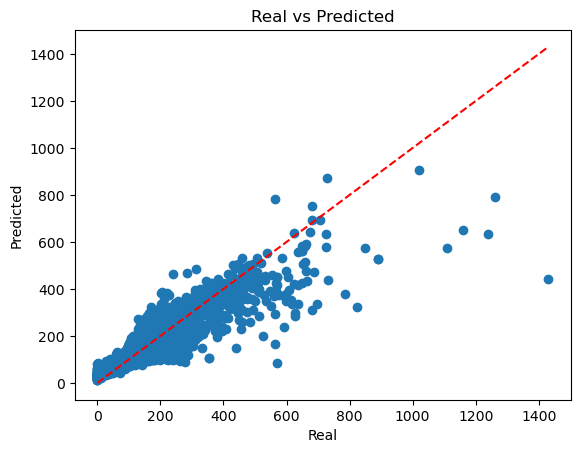

In [195]:
import matplotlib.pyplot as plt

plt.scatter(y_test_original, predictions_original)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r--')  # Línea ideal
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Real vs Predicted')
plt.show()

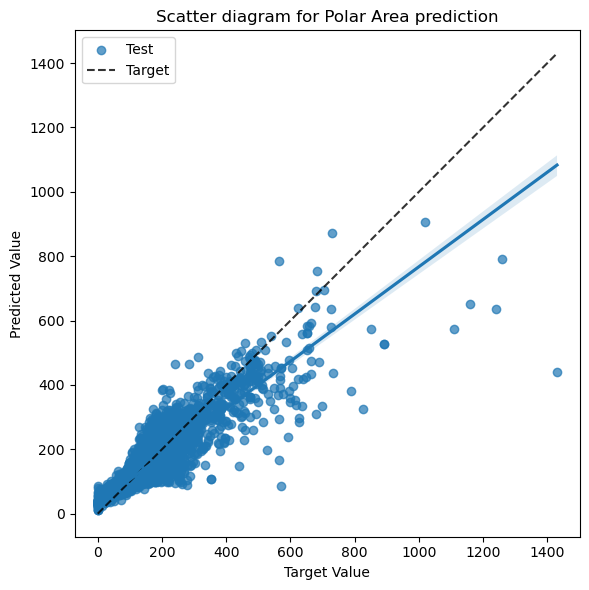

In [197]:
# Create the plot
plt.figure(figsize=(6, 6))


# Plot Test
plt.scatter(y_test_original, predictions_original, label='Test', alpha=0.7)

# Línea y = x
min_val = min(np.min(y_test_original), np.min(predictions_original))
max_val = max(np.max(y_test_original), np.max(predictions_original))
plt.plot([min_val, max_val], [min_val, max_val], 'k--',label='Target', alpha=0.8)

# Línea de regresión ajustada
sns.regplot(x=y_test_original, y=predictions_original, scatter=False)

plt.xlabel('Target Value')
plt.ylabel('Predicted Value')
plt.title('Scatter diagram for Polar Area prediction')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()


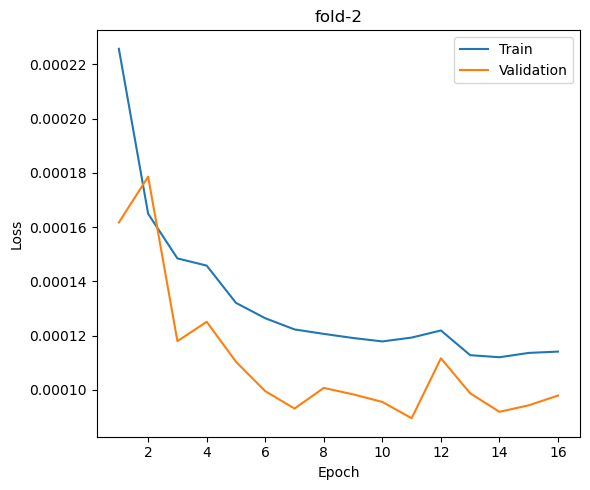

In [199]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Create the plot
plt.figure(figsize=(6, 5))

plt.plot(epochs, train_loss, label='Train')
plt.plot(epochs, val_loss, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('fold-2')
plt.legend()
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Save the figure
# plt.savefig('training_loss_fold2.png', dpi=300)


#### Retraining
IT was aditional only to chek if it was able to improve the training. But the resul wasn't better

In [207]:
# Load model
from tensorflow.keras.models import load_model
model = load_model('models/modelo_smiles.keras', compile=False)

In [209]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# REtrain
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_test, y_test_scaled),
    batch_size=32,
    epochs=30,  
    verbose=1,
    callbacks=[early_stop]
)
model.save('models/modelo_smilesV2.keras')

In [ ]:
loss, mae = model.evaluate(X_test, y_test_scaled)
print(f'Mean Absolute Error: {mae:.4f}')

In [ ]:
# Predicting on the full test set
predictions = model.predict(X_test)

# Denormalize predictions (convert them to the original scale)
predictions_original = scaler.inverse_transform(predictions)

# Denormalize the real labels (y_test) so they are on the same scale
y_test_original = scaler.inverse_transform(y_test_scaled)

# Show some examples comparing the predictions with the real values
import numpy as np
for i in range(10): # Show only 10 examples
    print(f"Real: {y_test_original[i][0]:.4f} | Predicted: {predictions_original[i][0]:.4f}")

### Architecture model modifaied

Conv1D(64, kernel_size=3, activation="relu") and GlobalMaxPooling1D() were remuved from original model.

In [233]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

def build_model(vocab_size, max_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_shape=(max_length,)),
        GRU(64, return_sequences=True),
        Dropout(0.3),
        GRU(32),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="linear")  # Para regresión
    ])
    return model


In [235]:
from tensorflow.keras.callbacks import EarlyStopping

# Use EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_scaled,
    validation_data=(X_test, y_test_scaled),
    batch_size=32,
    epochs=50,
    verbose=1,
    callbacks=[early_stop])

model.save('modelo_smilesDropout.keras')

Epoch 1/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 800s 209ms/step - loss: 3.1553e-04 - mae: 0.0105 - val_loss: 1.2992e-04 - val_mae: 0.0066
Epoch 2/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 1820s 479ms/step - loss: 1.6438e-04 - mae: 0.0075 - val_loss: 1.0928e-04 - val_mae: 0.0067
Epoch 3/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 723s 190ms/step - loss: 1.7940e-04 - mae: 0.0076 - val_loss: 9.1267e-05 - val_mae: 0.0059
Epoch 4/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 728s 192ms/step - loss: 1.3972e-04 - mae: 0.0068 - val_loss: 8.5677e-05 - val_mae: 0.0056
Epoch 5/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 722s 190ms/step - loss: 1.4639e-04 - mae: 0.0068 - val_loss: 8.8919e-05 - val_mae: 0.0055
Epoch 6/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 705s 186ms/step - loss: 1.2118e-04 - mae: 0.0064 - val_loss: 9.3603e-05 - val_mae: 0.0059
Epoch 7/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 1100s 290ms/step - loss: 1.2784e-04 - mae: 0.0064 - val_loss: 8.8736e-05 - val_mae: 0.0058
Epoch 8/50
3799/3799 ━━━━━━━━━━━━━━━━━━━━ 788s 207ms/step - loss: 1.3076e-

In [237]:
loss, mae = model.evaluate(X_test, y_test_scaled)
print(f'Mean Absolute Error: {mae:.4f}')

950/950 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - loss: 9.6839e-05 - mae: 0.0056
Mean Absolute Error: 0.0056


In [239]:
# Predicting on the full test set
predictions = model.predict(X_test)

# Denormalize predictions (convert them to the original scale)
predictions_original = scaler.inverse_transform(predictions)

# Denormalize the real labels (y_test) so they are on the same scale
y_test_original = scaler.inverse_transform(y_test_scaled)

# Show some examples comparing the predictions with the real values
import numpy as np
for i in range(10): # Show only 10 examples
    print(f"Real: {y_test_original[i][0]:.4f} | Predicted: {predictions_original[i][0]:.4f}")

950/950 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step
Real: 82.2000 | Predicted: 111.2172
Real: 94.6000 | Predicted: 94.3297
Real: 96.1000 | Predicted: 104.5788
Real: 107.0000 | Predicted: 117.1273
Real: 131.0000 | Predicted: 150.0210
Real: 107.0000 | Predicted: 89.4104
Real: 132.0000 | Predicted: 116.1707
Real: 114.0000 | Predicted: 125.1038
Real: 76.3000 | Predicted: 116.1147
Real: 73.5000 | Predicted: 78.3180


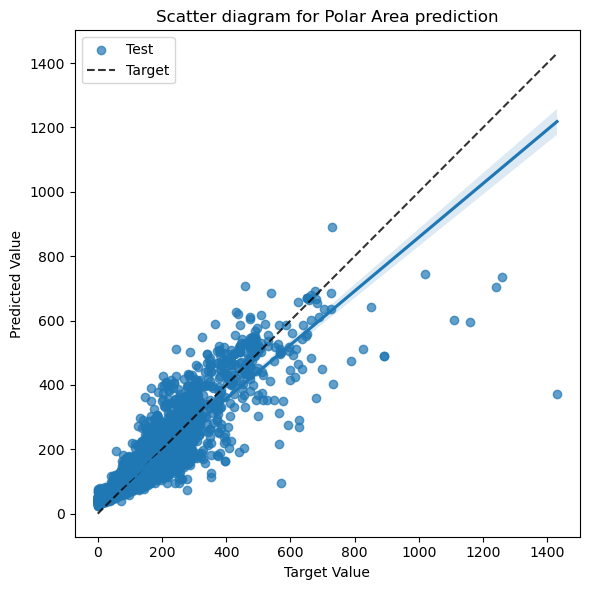

In [241]:
# Create the plot
plt.figure(figsize=(6, 6))


# Plot Test
plt.scatter(y_test_original, predictions_original, label='Test', alpha=0.7)

# Línea y = x
min_val = min(np.min(y_test_original), np.min(predictions_original))
max_val = max(np.max(y_test_original), np.max(predictions_original))
plt.plot([min_val, max_val], [min_val, max_val], 'k--',label='Target', alpha=0.8)

# Línea de regresión ajustada
sns.regplot(x=y_test_original, y=predictions_original, scatter=False)

plt.xlabel('Target Value')
plt.ylabel('Predicted Value')
plt.title('Scatter diagram for Polar Area prediction')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()

## Other data

This data as used to compare our model results with one already reported. The same dataset was used.
Dhandekar, P., Joseph, M., 2022. Ensemble Creation via Anchored Regularization for Unsupervised Aspect Extraction. 

In [121]:
df2=pd.read_csv('lipophilicity_clean_dataset.csv')

In [123]:
df2.head()

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,Molecular Formula,Smiles,Inchi Key,Inchi,Withdrawn Flag,Orphan
0,CHEMBL48361,DABIGATRAN,BIBR 953 ZW|BIBR-953|BIBR-953-ZW|DABIGATRAN|PR...,Small molecule,3.0,471.52,88,164,2.99,150.22,C25H25N7O3,Cn1c(CNc2ccc(C(=N)N)cc2)nc2cc(C(=O)N(CCC(=O)O)...,YBSJFWOBGCMAKL-UHFFFAOYSA-N,InChI=1S/C25H25N7O3/c1-31-20-10-7-17(25(35)32(...,False,0
1,CHEMBL878,METOLAZONE,DIULO|METAZOLINE|METENIX|METOLAZONA|METOLAZONE...,Small molecule,4.0,365.84,165,562,2.71,92.50,C16H16ClN3O3S,Cc1ccccc1N1C(=O)c2cc(S(N)(=O)=O)c(Cl)cc2NC1C,AQCHWTWZEMGIFD-UHFFFAOYSA-N,InChI=1S/C16H16ClN3O3S/c1-9-5-3-4-6-14(9)20-10...,False,0
2,CHEMBL1088752,LOSMAPIMOD,FTX-1821|FTX1821|GSK-AHAB|GSKAHAB|GW-856553|GW...,Small molecule,3.0,383.47,306,358,3.86,71.09,C22H26FN3O2,Cc1c(F)cc(C(=O)NC2CC2)cc1-c1ccc(C(=O)NCC(C)(C)...,KKYABQBFGDZVNQ-UHFFFAOYSA-N,InChI=1S/C22H26FN3O2/c1-13-17(9-15(10-18(13)23...,False,0
3,CHEMBL1201,THIOTHIXENE,(Z)-THIOTHIXENE|CIS-THIOTHIXENE|CP-12252-1|NAV...,Small molecule,4.0,443.64,117,214,3.47,43.86,C23H29N3O2S2,CN1CCN(CC/C=C2/c3ccccc3Sc3ccc(S(=O)(=O)N(C)C)c...,GFBKORZTTCHDGY-UWVJOHFNSA-N,"InChI=1S/C23H29N3O2S2/c1-24(2)30(27,28)18-10-1...",False,0
4,CHEMBL407,FLUMAZENIL,ANEXATE|FLUMAZENIL|FLUMAZEPIL|Flumazepil|LANEX...,Small molecule,4.0,303.29,221,778,1.77,64.43,C15H14FN3O3,CCOC(=O)c1ncn2c1CN(C)C(=O)c1cc(F)ccc1-2,OFBIFZUFASYYRE-UHFFFAOYSA-N,InChI=1S/C15H14FN3O3/c1-3-22-15(21)13-12-7-18(...,False,0


In [125]:
df_lipo = df2[["Smiles", "AlogP"]].dropna()  # Keep only SMILES & AlogP columns
df_lipo.head()

,Smiles,AlogP
0,Cn1c(CNc2ccc(C(=N)N)cc2)nc2cc(C(=O)N(CCC(=O)O)...,2.99
1,Cc1ccccc1N1C(=O)c2cc(S(N)(=O)=O)c(Cl)cc2NC1C,2.71
2,Cc1c(F)cc(C(=O)NC2CC2)cc1-c1ccc(C(=O)NCC(C)(C)...,3.86
3,CN1CCN(CC/C=C2/c3ccccc3Sc3ccc(S(=O)(=O)N(C)C)c...,3.47
4,CCOC(=O)c1ncn2c1CN(C)C(=O)c1cc(F)ccc1-2,1.77


In [127]:
# 1. Check if the 'smiles' column exists
if 'Smiles' in df_lipo.columns:
    
    # 2. Create the 'mol' column with RDKit molecule objects
    df_lipo['mol'] = df_lipo['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))
    
    # 3. Count invalid SMILES
    n_invalid = df_lipo['mol'].isnull().sum()
    print(f"Number of invalid SMILES: {n_invalid} out of {len(df_lipo)}")

    # 4. Remove invalid SMILES
    df_clean2 = df_lipo.dropna(subset=['mol']).copy()
    print(f"{len(df_clean2)} valid SMILES remaining.")

    # 5. Optional: Save the cleaned DataFrame
    df_clean2.to_csv('cleaned_smiles2.csv', index=False)
    print("Cleaned file saved as 'cleaned_smiles2.csv'.")

else:
    print("❌ Error: 'smiles' column does not exist in the DataFrame.")

Number of invalid SMILES: 0 out of 5458
5458 valid SMILES remaining.
Cleaned file saved as 'cleaned_smiles2.csv'.


In [128]:
from sklearn.model_selection import train_test_split

# 1. Build vocabulary of unique characters in SMILES
unique_chars = sorted(set("".join(df_clean2["Smiles"])))
char_to_index = {char: idx + 1 for idx, char in enumerate(unique_chars)}
char_to_index["PAD"] = 0  # Padding token

# 2. Determine maximum sequence length
max_length = df_clean2["Smiles"].str.len().max()

# 3. Function to encode SMILES into sequences of indices
def encode_smiles(smiles):
    sequence = [char_to_index[char] for char in smiles]
    padding = [0] * (max_length - len(sequence))
    return sequence + padding

# 4. Apply encoding to the dataset
df_clean2["SMILES_seq"] = df_clean2["Smiles"].apply(encode_smiles)

# 5. Convert to numpy arrays
X2 = np.vstack(df_clean2["SMILES_seq"].values)
y2 = df_clean2["AlogP"].values

# 6. Train/test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

In [131]:
X2_train = X2_train.reshape((X2_train.shape[0], X2_train.shape[1], 1))
X2_test = X2_test.reshape((X2_test.shape[0], X2_test.shape[1], 1))
print(f"X2_train: {X2_train.shape},X2_test: {X2_test.shape} ")

X2_train: (4366, 190, 1),X2_test: (1092, 190, 1) 


In [133]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y2_train_scaled = scaler.fit_transform(y2_train.reshape(-1, 1))
y2_test_scaled = scaler.transform(y2_test.reshape(-1, 1))



# Print min and max to verify normalization
print(f"After normalization: min={y2_train_scaled.min()}, max={y2_train_scaled.max()}")

After normalization: min=0.0, max=0.9999999999999999


In [135]:
# Parameters
VOCAB_SIZE = len(char_to_index)
MAX_LENGTH = X2_train.shape[1]

def build_model(vocab_size, max_length):
    model = keras.Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_shape=(max_length,)),  # Embedding layer ensures 3D input
        Conv1D(64, kernel_size=3, activation="relu"),
        GlobalMaxPooling1D(),
        tf.keras.layers.Reshape((-1, 1)),  # Ensure input to GRU is 3D
        GRU(64, return_sequences=True),
        GRU(32),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="linear")  # Regression output
    ])
    
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Build the model
model = build_model(VOCAB_SIZE, MAX_LENGTH)

# Print model summary
model.summary()

C:\Users\romin\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 190, 128)       │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 188, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 64, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 64, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,489 (216.75 KB)

 Trainable params: 55,489 (216.75 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
from tensorflow.keras.callbacks import EarlyStopping

# Use EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history2 = model.fit(
    X2_train, y2_train_scaled,
    validation_data=(X2_test, y2_test_scaled),
    batch_size=32,
    epochs=50,
    verbose=1,
    callbacks=[early_stop])

model.save('modelo_smilesLipo.keras')

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 0.0648 - mae: 0.1975 - val_loss: 0.0094 - val_mae: 0.0763
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0147 - mae: 0.0955 - val_loss: 0.0088 - val_mae: 0.0741
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0125 - mae: 0.0888 - val_loss: 0.0093 - val_mae: 0.0761
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0103 - mae: 0.0795 - val_loss: 0.0086 - val_mae: 0.0738
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0097 - mae: 0.0771 - val_loss: 0.0087 - val_mae: 0.0741
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0092 - mae: 0.0754 - val_loss: 0.0062 - val_mae: 0.0625
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0076 - mae: 0.0684 - val_loss: 0.0059 - val_mae: 0.0603
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0070 - mae: 0.0661 - val_loss: 0.0055 - val_mae: 0.0580
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms

In [139]:
loss, mae = model.evaluate(X2_test, y2_test_scaled)
print(f'Mean Absolute Error: {mae:.4f}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - mae: 0.0505
Mean Absolute Error: 0.0510


In [141]:
# Predicting on the full test set
predictions2 = model.predict(X2_test)

# Denormalize predictions (convert them to the original scale)
predictions2_original = scaler.inverse_transform(predictions2)

# Denormalize the real labels (y_test) so they are on the same scale
y2_test_original = scaler.inverse_transform(y2_test_scaled)

# Show some examples comparing the predictions with the real values
import numpy as np
for i in range(10): # Show only 10 examples
    print(f"Real: {y2_test_original[i][0]:.4f} | Predicted: {predictions2_original[i][0]:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Real: 4.2200 | Predicted: 3.5953
Real: 4.3100 | Predicted: 3.2888
Real: 4.5700 | Predicted: 4.4909
Real: 3.6000 | Predicted: 3.2985
Real: 0.9700 | Predicted: 1.2171
Real: 2.3500 | Predicted: 3.5138
Real: 3.1700 | Predicted: 2.8801
Real: 4.6200 | Predicted: 4.9001
Real: 2.5200 | Predicted: 3.5058
Real: 0.4500 | Predicted: 0.1572


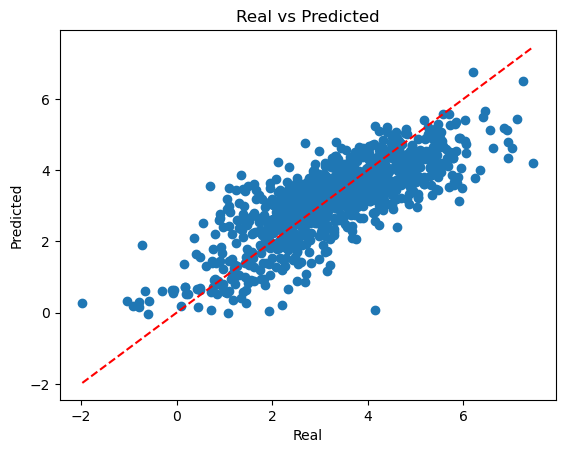

In [143]:
import matplotlib.pyplot as plt

plt.scatter(y2_test_original, predictions2_original)
plt.plot([min(y2_test_original), max(y2_test_original)], [min(y2_test_original), max(y2_test_original)], 'r--')  # Línea ideal
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Real vs Predicted')
plt.show()

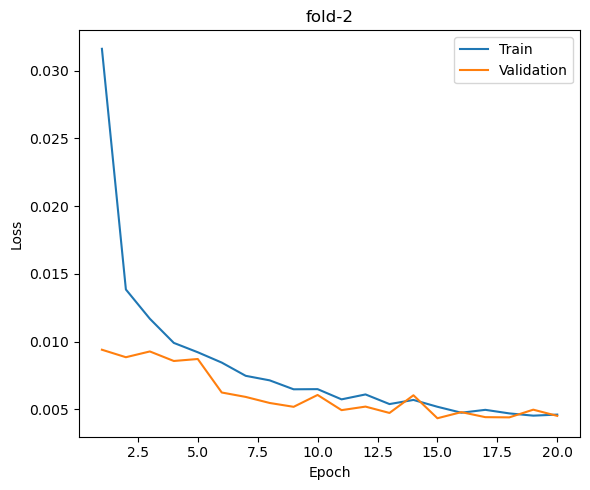

In [165]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Create the plot
plt.figure(figsize=(6, 5))

plt.plot(epochs, train_loss, label='Train')
plt.plot(epochs, val_loss, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('fold-2')
plt.legend()
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Save the figure
# plt.savefig('training_loss_fold2.png', dpi=300)


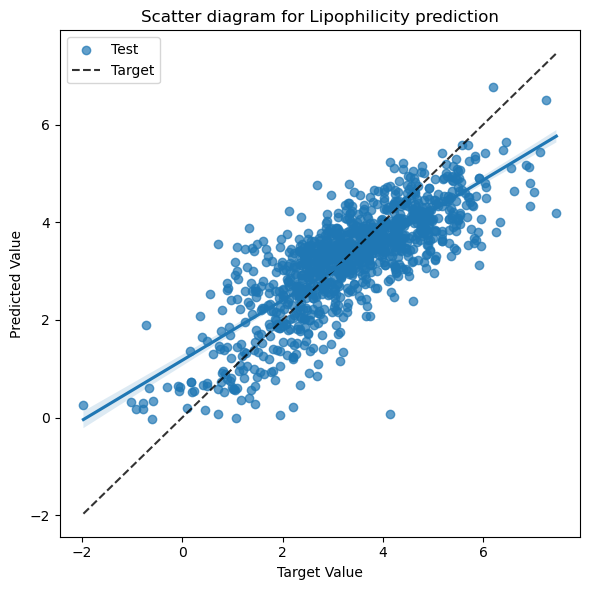

In [161]:
# Create the plot
plt.figure(figsize=(6, 6))


# Plot Test
plt.scatter(y2_test_original, predictions2_original, label='Test', alpha=0.7)

# Línea y = x
min_val = min(np.min(y2_test_original), np.min(predictions2_original))
max_val = max(np.max(y2_test_original), np.max(predictions2_original))
plt.plot([min_val, max_val], [min_val, max_val], 'k--',label='Target', alpha=0.8)

# Línea de regresión ajustada
sns.regplot(x=y2_test_original, y=predictions2_original, scatter=False, )

plt.xlabel('Target Value')
plt.ylabel('Predicted Value')
plt.title('Scatter diagram for Lipophilicity prediction')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()


## Conclusion
In this work, a deep learning model was developed for molecular property prediction using SMILES-based representations. The proposed architecture combined an embedding layer with convolutional and recurrent layers, specifically Conv1D and GRU, to capture local and sequential patterns within molecular structures.
The results highlighted that there is no evidence that the inclusion of convolutional layers significantly improves performance compared to the simpler GRU-based model, suggesting that the sequential dependencies encoded in SMILES strings could be effectively captured solely by recurrent architectures. Furthermore, the analysis revealed that model accuracy decreased for molecules with high polar area values, which was attributed to the imbalance in the dataset.